This notebook is made with reference to [kaggle Notebook](https://www.kaggle.com/code/rafffael/geting-started-movie-recommendation-with-eda-demo/notebook)

### Config

In [2]:
import gc
import sys
import warnings
from pathlib import Path
from glob import glob

import os

import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
warnings.simplefilter("ignore")

from collections import defaultdict, Counter
from functools import partial
import json
import pickle
from pywaffle import Waffle
import squarify
import scipy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

In [4]:
INPUT_DIR = "../data/input/TMDB/"
OUTPUT_DIR = "../data/output/"

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [6]:
"""
# kaggle APIからdatasetをzip形式でDownload
# zipファイルをINPUT_DIRに解凍するコード
# 初めの一回のみ動かす

import shutil
shutil.unpack_archive(INPUT_DIR+'tmdb-movie-metadata.zip', INPUT_DIR)
"""


### load data and preprocess

In [36]:
credit = pd.read_csv(INPUT_DIR+'tmdb_5000_credits.csv')
movie = pd.read_csv(INPUT_DIR+'tmdb_5000_movies.csv')

In [41]:
credit.columns = ['id', 'title', 'cast', 'crew']
movie_df = movie.merge(credit[['id', 'cast', 'crew']], on='id')
movie_df.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


In [43]:
# preprocess
# to datetime
movie_df['release_date'] = pd.to_datetime(movie_df['release_date'])
movie_df['release_year'] = movie_df['release_date'].dt.year
movie_df['release_month'] = movie_df['release_date'].dt.month

In [44]:
# json形式で格納されているcolumnsに対して前処理
json_columns = {'cast', 'crew', 'genres', 'keywords', 'production_countries',
                'production_companies', 'spoken_languages'}

for c in json_columns:
    movie_df[c] = movie_df[c].apply(json.loads)
    if c != "crew":
        movie_df[c] = movie_df[c].apply(lambda row: [x["name"] for x in row])

In [45]:
# create director writer and producer columns
def get_job(job, row):
    person_name = [x['name'] for x in row if x['job']==job]
    return person_name[0] if len(person_name) else np.nan

movie_df["director"] = movie_df["crew"].apply(partial(get_job, "Director"))
movie_df["writer"]   = movie_df["crew"].apply(partial(get_job, "Writer"))
movie_df["producer"] = movie_df["crew"].apply(partial(get_job, "Producer"))

# create profit column
movie_df["profit"] = movie_df["revenue"] - movie_df["budget"]

In [46]:
# 最頻値を用いて欠損値埋め
for col in ['runtime', 'release_year', 'release_month']:
    movie_df[col] = movie_df[col].fillna(movie_df[col].mode().iloc[0])

In [88]:
movie_df.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'cast', 'crew', 'release_year', 'release_month',
       'director', 'writer', 'producer', 'profit'],
      dtype='object')

In [47]:
movie_df.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,vote_average,vote_count,cast,crew,release_year,release_month,director,writer,producer,profit
0,237000000,"[Action, Adventure, Fantasy, Science Fiction]",http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...",...,7.2,11800,"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[{'credit_id': '52fe48009251416c750aca23', 'de...",2009.0,12.0,James Cameron,James Cameron,James Cameron,2550965087


### Data Visualization

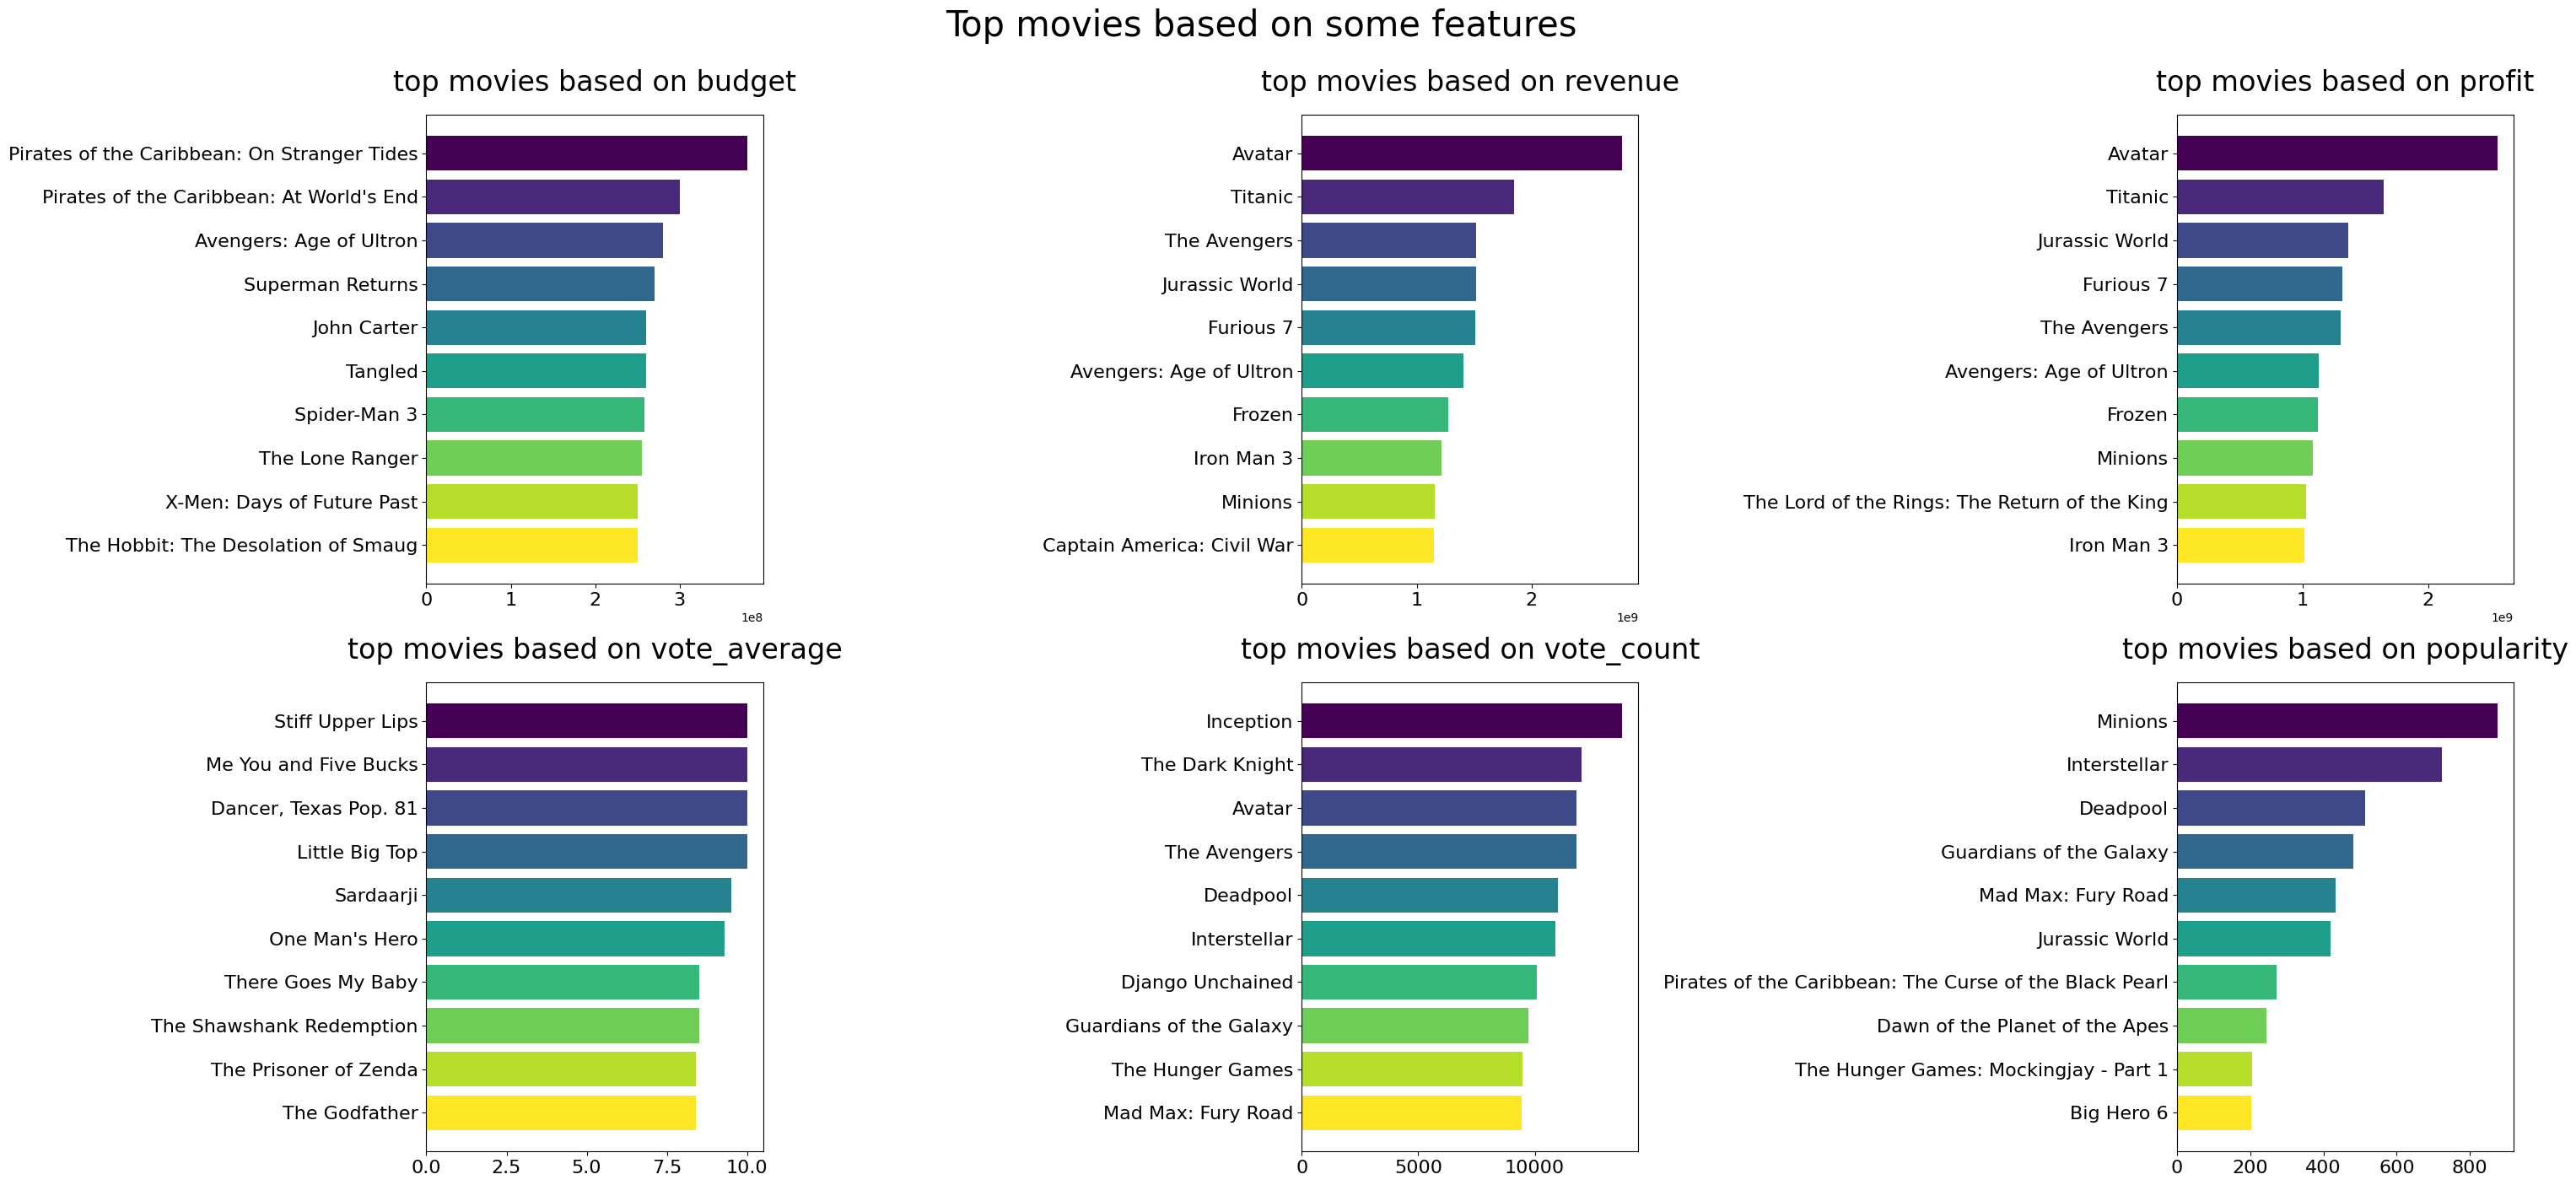

In [49]:
# 各項目のtop10を可視化
# ただ、vote_averageはvote_countが低いものも入ってしまっているので、修正が必要

top_movie_num = 10
top_movie_based_on = \
    ['budget', 'revenue', 'profit', 'vote_average', 'vote_count', 'popularity']

fig, ax = plt.subplots(len(top_movie_based_on)//3, 3, figsize=(30, 14))
colors = plt.cm.get_cmap('viridis', top_movie_num)

for i, col in enumerate(top_movie_based_on):
    top_movies_by = movie_df.sort_values(by=[col], ascending=False).head(top_movie_num)
    r, c = i//3, i%3
    ax[r][c].barh(top_movies_by['title'], top_movies_by[col], color=colors.colors)
    ax[r][c].set_title(f'top movies based on {col}', fontsize=24, pad=20)
    ax[r][c].tick_params(axis='both', which='major', labelsize=16)
    ax[r][c].invert_yaxis()

plt.suptitle('Top movies based on some features', fontsize=30, y=1)
fig.tight_layout()

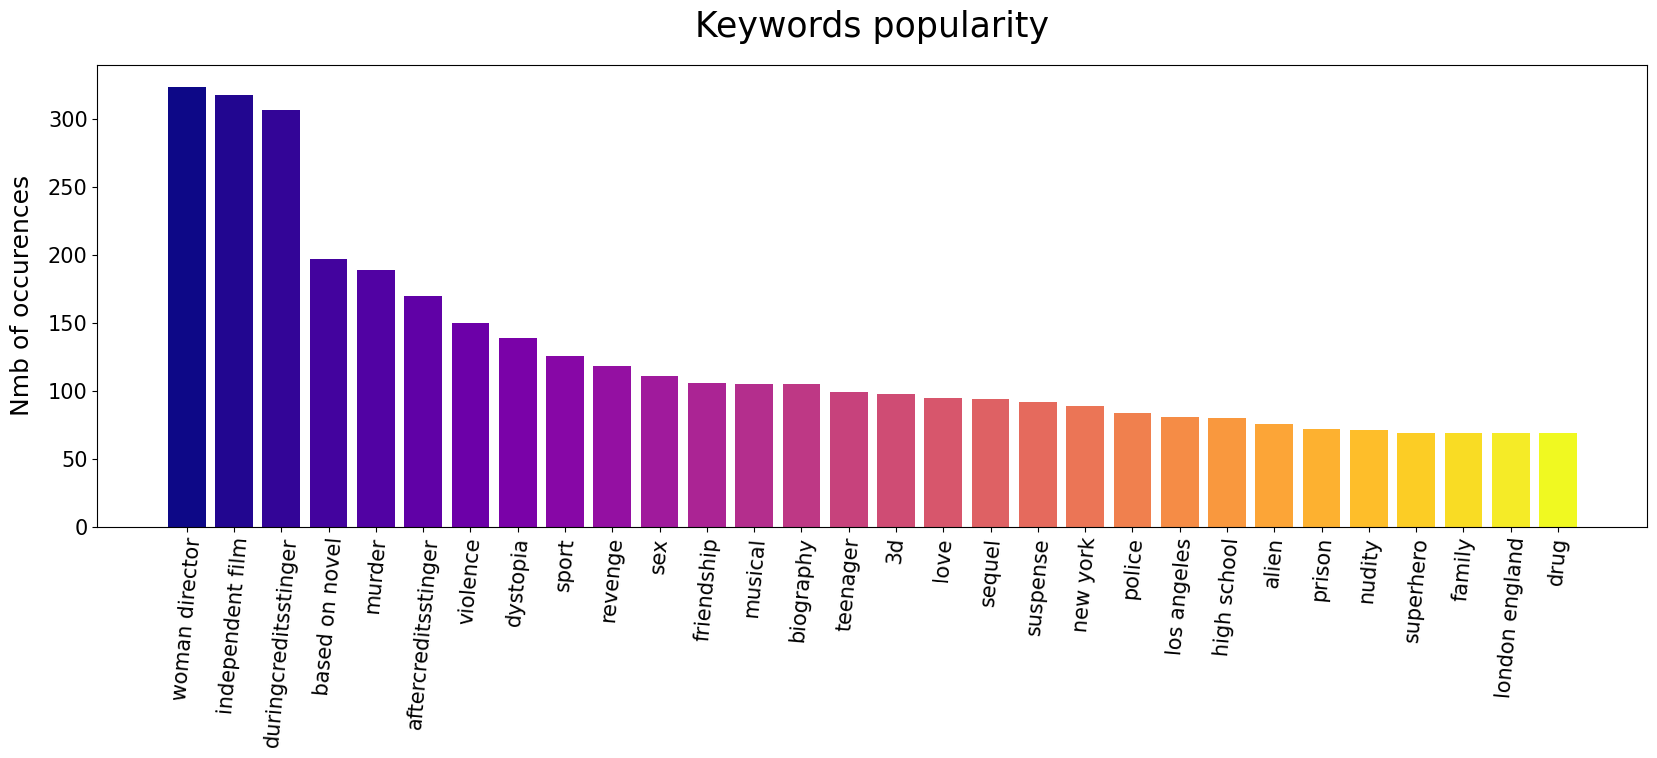

In [56]:
# top keywordsの可視化

top_keywords_num = 30
# keywordsをkeywords_flattenに格納
keywords_flatten = sum(movie_df['keywords'].values, [])
keywords_info = Counter(keywords_flatten)
# most_commonで出現回数順に要素を取得(ele(key), count(val))
top_keywords = dict(keywords_info.most_common(top_keywords_num))

plt.figure(figsize=(20, 6))
plt.xticks(rotation=85, fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Nmb of occurences', fontsize=18, labelpad=10)
plt.bar(top_keywords.keys(), top_keywords.values(), align='center',
        color=plt.cm.get_cmap('plasma', top_keywords_num).colors)
plt.title('Keywords popularity', fontsize=25, pad=20)
plt.show()

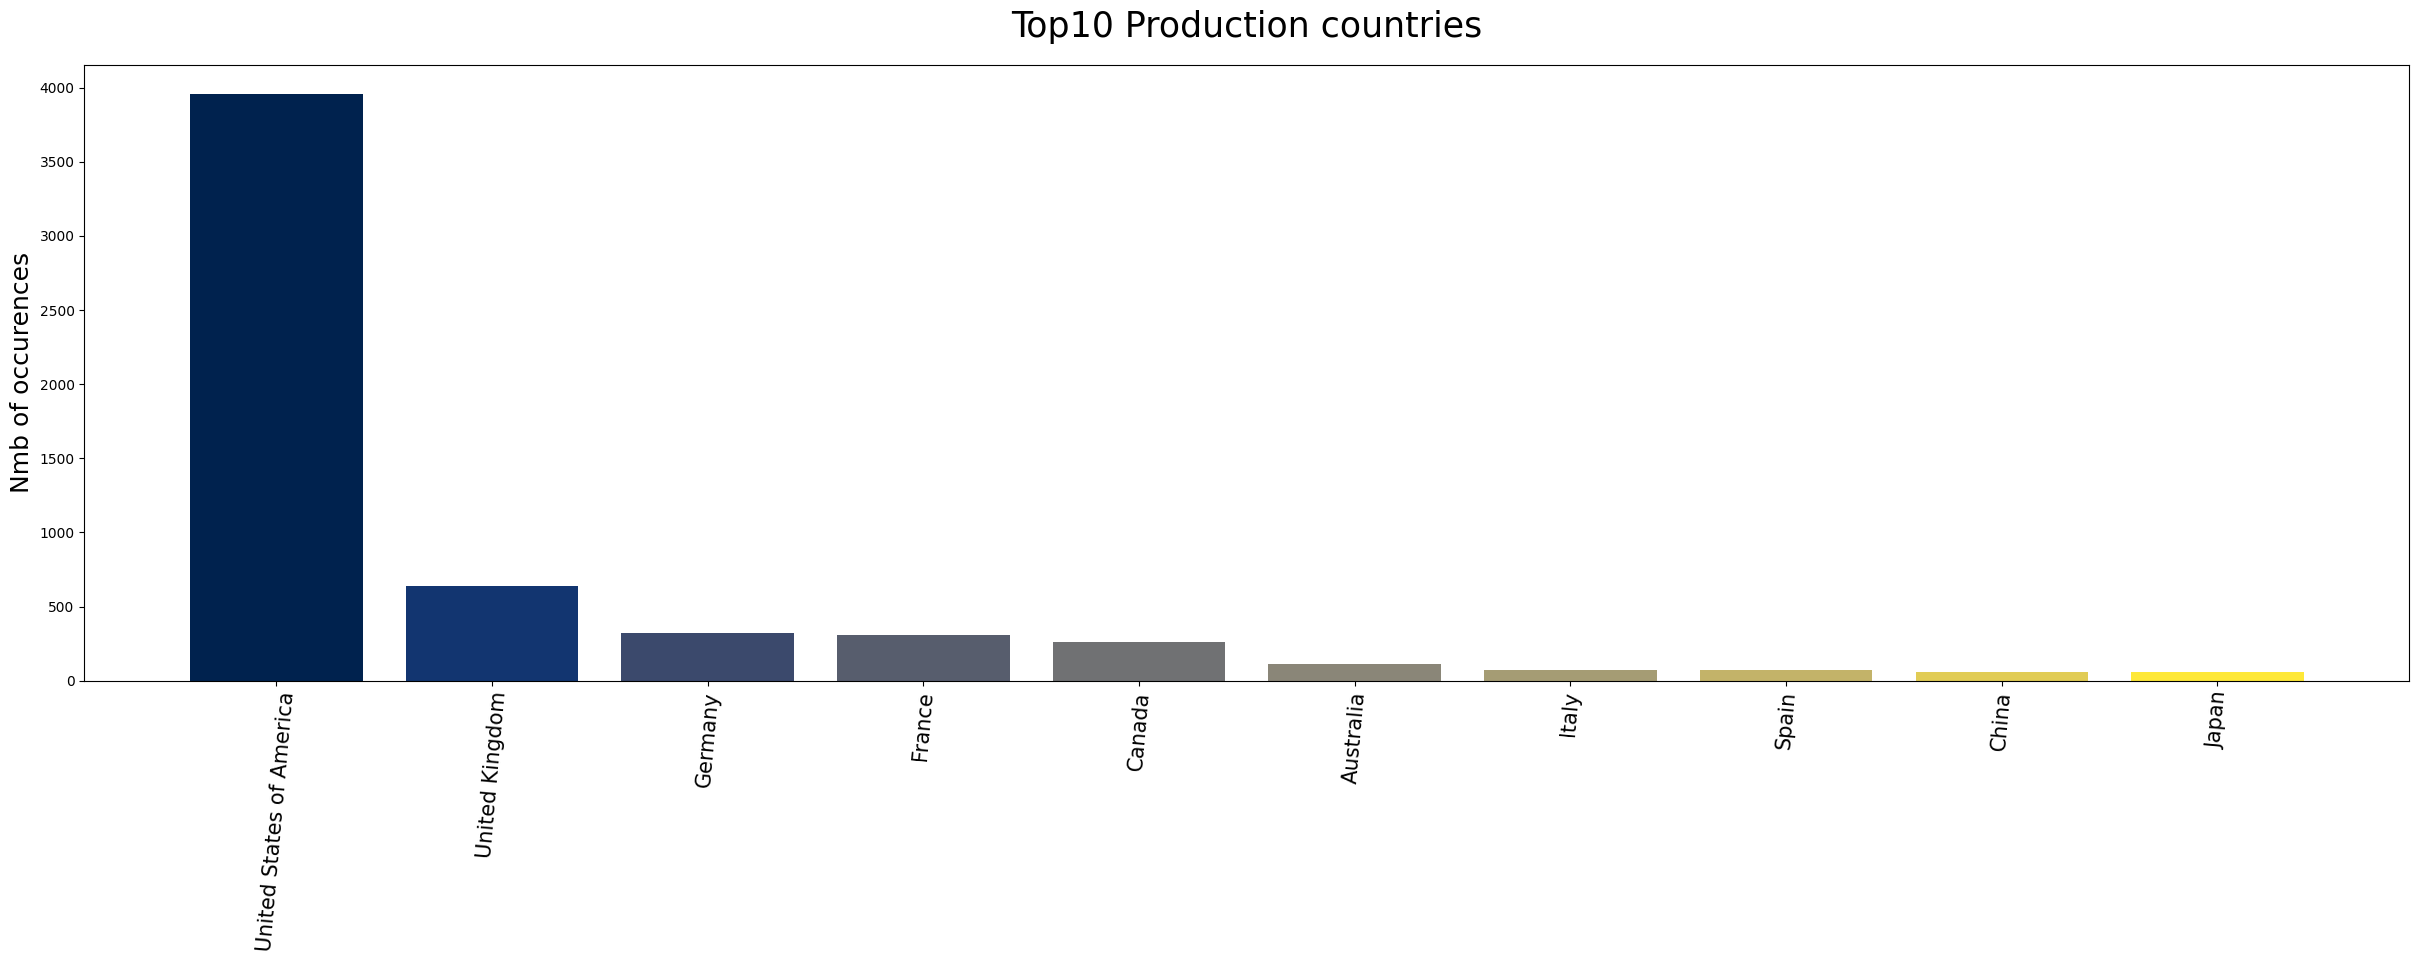

In [62]:
# production countriesを可視化

top_countries_num = 10
production_countries_flatten = sum(movie_df['production_countries'].values, [])
production_countries_info = Counter(production_countries_flatten)
top_production_countries = production_countries_info.most_common(top_countries_num)

plt.figure(figsize=(30, 8))
plt.xticks(rotation=85, fontsize=15)
plt.ylabel('Nmb of occurences', fontsize=18)
plt.title('Top10 Production countries', fontsize=25, pad=20)
plt.bar(dict(top_production_countries).keys(), dict(top_production_countries).values(),
        color=plt.cm.get_cmap('cividis', top_countries_num).colors)
plt.show()

In [83]:
# 日本のものは？ -> 意外と知らないものもある
japan_movie = []
for i in range(len(movie_df)):
    if 'Japan' in movie_df['production_countries'].iloc[i]:
        japan_movie.append(movie_df['title'].iloc[i])
print(japan_movie[:5])

['Furious 7', 'Shin Godzilla', 'Warcraft', 'The Last Samurai', 'Final Fantasy: The Spirits Within']


<Axes: title={'center': 'Movie release year'}, ylabel='Frequency'>

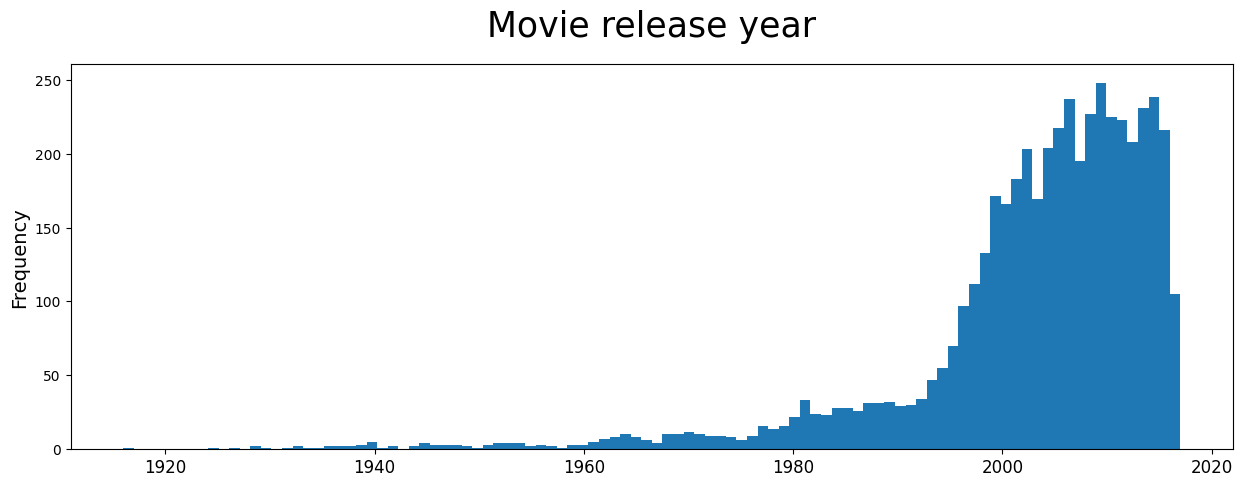

In [84]:
# release_year, release_monthを可視化
plt.xticks(fontsize=12)
plt.ylabel('Nmb of occurences', fontsize=14)
plt.title('Movie release year', fontsize=25, pad=20)
movie_df['release_year'].plot.hist(figsize=(15, 5), bins=100)

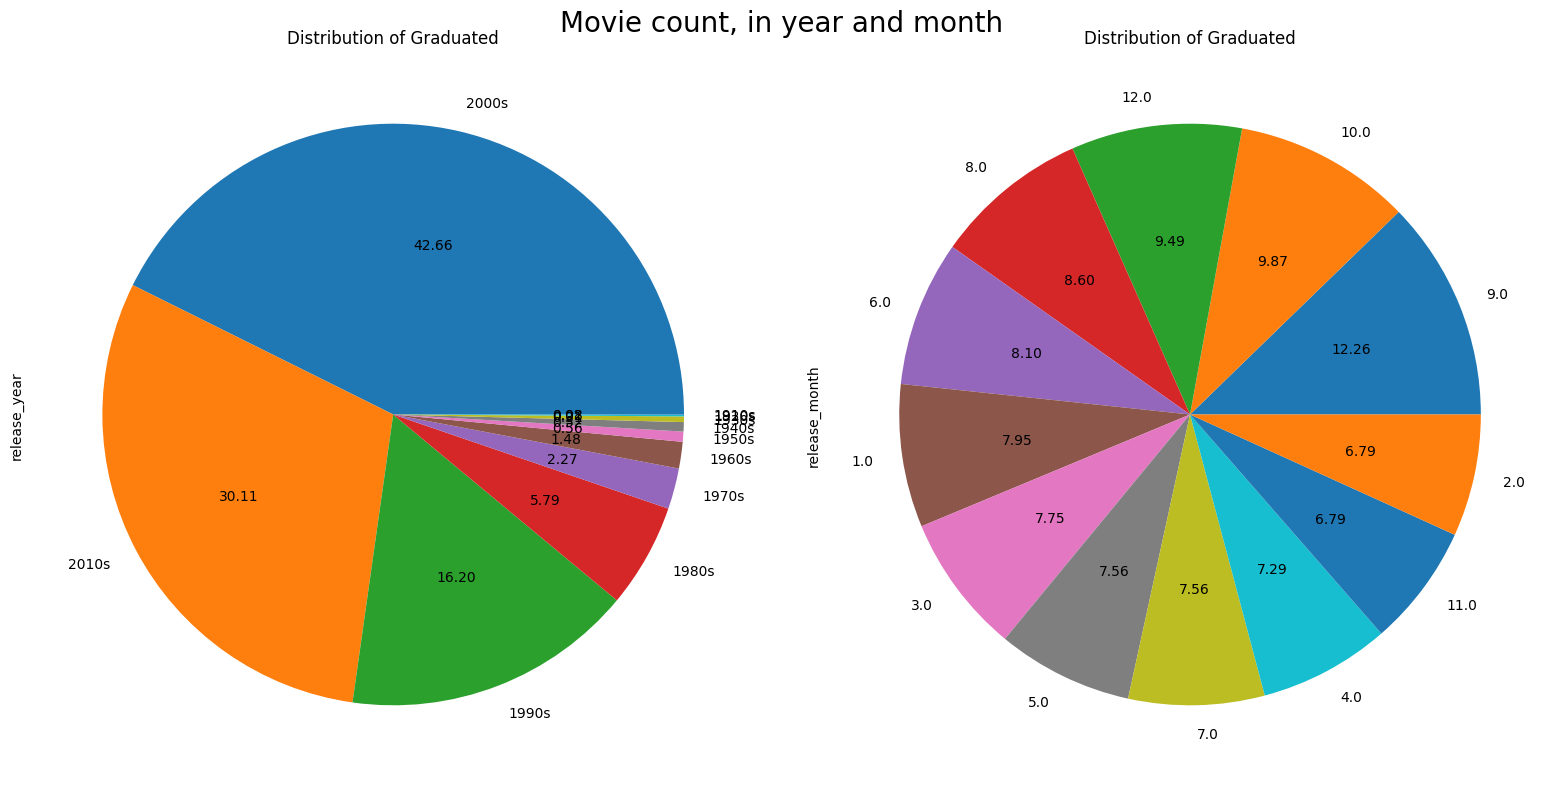

In [86]:
# correlation

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Movie count, in year and month', fontsize=20)

movie_count_in_10th_year = movie_df['release_year'].dropna().apply(lambda x:str(int(x)//10*10)+'s').value_counts()
movie_count_in_month = movie_df['release_month'].value_counts()

movie_count_in_10th_year.plot.pie(title='Distribution of Graduated',
                                    ax=ax[0], autopct='%.2f')
movie_count_in_month.plot.pie(title='Distribution of Graduated',
                                ax=ax[1], autopct='%.2f')
fig.tight_layout()

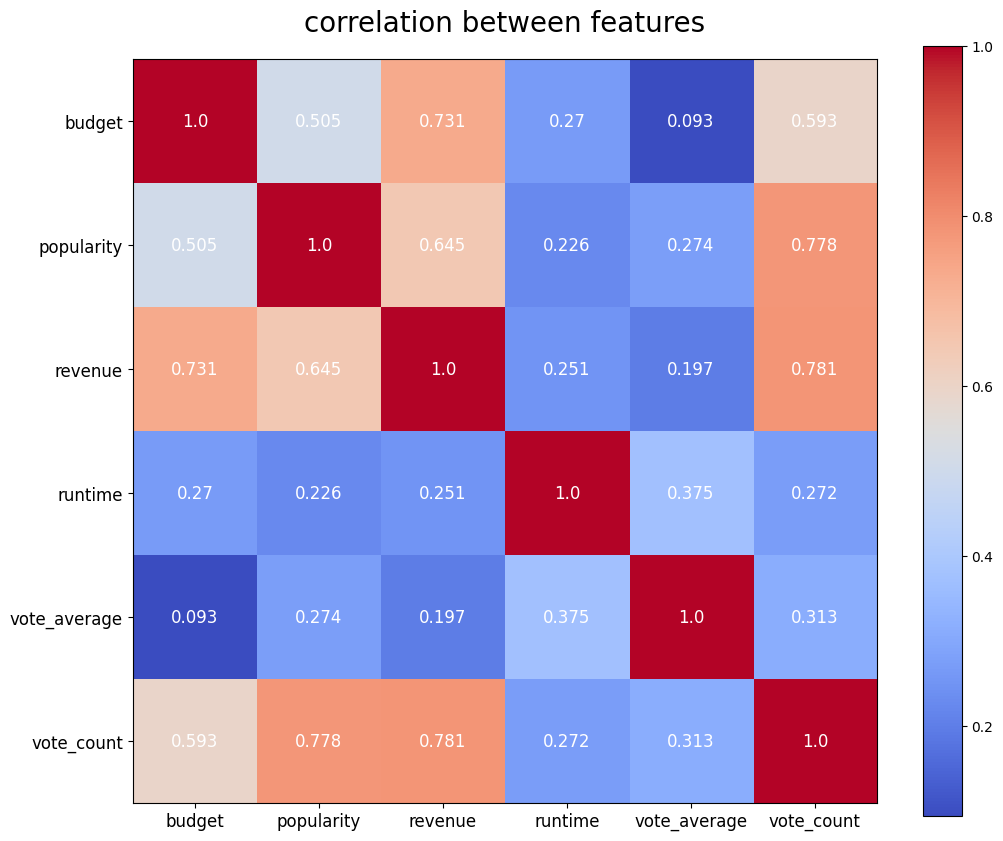

In [87]:
matrix = movie_df[['budget', 'popularity', 'revenue',
                    'runtime', 'vote_average', 'vote_count']].corr()

f, ax = plt.subplots(figsize=(12, 10))
plt.title('correlation between features', fontsize=20, pad=20)
plt.xticks(range(len(matrix.index)), matrix.index, fontsize=12)
plt.yticks(range(len(matrix.index)), matrix.index, fontsize=12)

for i in range(len(matrix.index)):
    for j in range(len(matrix.index)):
        text = ax.text(j, i, round(matrix.iloc[i, j], 3), ha='center',
                        va='center', color='w', fontsize=12)
plt.imshow(matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()

<Axes: title={'center': 'Vote count'}, ylabel='Frequency'>

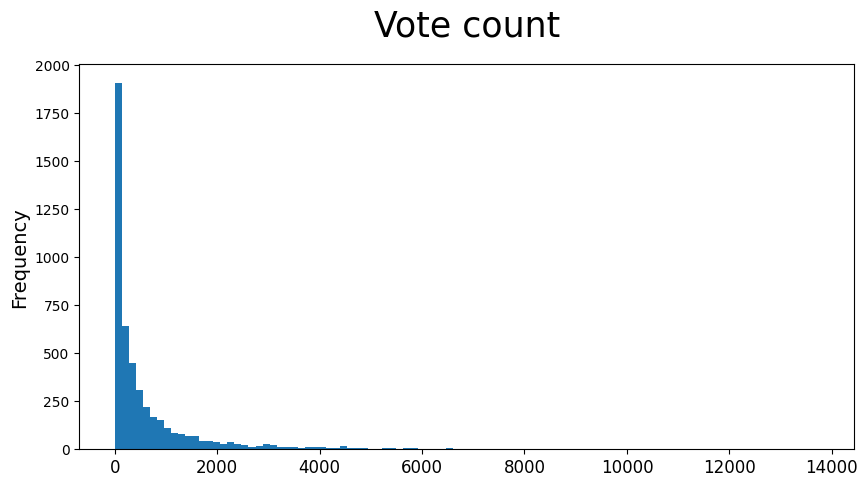

In [90]:
# vate_countを可視化
plt.xticks(fontsize=12)
plt.ylabel('Nmb of occurences', fontsize=14)
plt.title('Vote count', fontsize=25, pad=20)
movie_df['vote_count'].plot.hist(figsize=(10, 5), bins=100)